Wisieńka na torcie czyli penetracja przestrzeni ukrytej autoenkodera dla problemu wykrywania anomalii dla transakcji kartowych
Więcej https://krzysztofzdanowicz.com/2022/11/wykrywanie-anomalii-oraz-zdarzen-rzadkich/

In [1]:
# importujemy pakiety
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as K
from keras import regularizers
from imblearn.under_sampling import TomekLinks

#ustawiam ziarno pseudolosowania i udział zbioru testowego
RANDOM_SEED = 128262
TEST_PCT = 0.2

#ustawienia stylu grafik, w tym wypadku wykorzystałem schemat kolorów z xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # złoty podział
LABELS = ["Normal","Fraud"]

# wczytujemy zbiór danych
df = pd.read_csv("creditcard.csv")

In [2]:
#Normalizowanie oraz skalowanie danych, wymagane aby skorzystać z sieci neuronowej.
df_norm = df.copy()
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [3]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column

test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray


In [6]:
print(train_x.shape)

(227448, 30)


In [6]:
# Struktura warstw oraz parametry autoenkodera
nb_epoch =50
batch_size = 128
input_dim = train_x.shape[1] #kolumn mamy w tym wypadku 30
encoding_dim = 18
hidden_dim1 = 10 # typowo dajemy int(encoding_dim / 2)
hidden_dim2 = 6
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ), name='encoder_input')

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)

# dygresja, tworzę modelik enkodera żeby działać na przestrzeni ukrytej
encoder_model = Model(inputs = input_layer, outputs = encoder)


decoder_input = Input(shape=(hidden_dim2,), name='decoder_input')

decoder = Dense(hidden_dim2, activation='elu')(decoder_input)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

decoder_model = Model(inputs=decoder_input, outputs = decoder)

# teraz tworzymy model z warstwą wejściową oraz czterema warstwami gęstymi
auto_input = input_layer
auto_output = decoder_model(encoder)
autoencoder = Model(inputs=auto_input, outputs=auto_output)

# Konfiguracja procesu nauki poprzez skompilowanie modelu
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# Zapisanie modelu


cp = ModelCheckpoint(filepath="./run/vae/auto_for_fraud/autoencoder_fraud.h5",
                     save_best_only=True,
                     verbose=0)

# Podstawowa wizualizacja TensorBoard.
# To wywołanei zwrotne (callback) zapisuje log dla TensorBoard,
# co pozwala na wizualizację poprzez dynamiczy graf metryk na zbiorze treningowym oraz testowym
tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)



In [7]:
# TEN LISTING OPUSZCZAMY PRZY PONOWNYM PUSZCZANIU SKRYPTU
# Atrybut History.history to zapis wartości straty podczas treningu
history = autoencoder.fit(x=train_x, y=train_x,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_x, test_x),
                          verbose=1,
                          callbacks=[cp, tb]).history

Epoch 1/50
1777/1777 [==============================] - 2s 970us/step - loss: 0.5192 - accuracy: 0.6463 - val_loss: 0.5522 - val_accuracy: 0.6424
Epoch 2/50
1777/1777 [==============================] - 2s 892us/step - loss: 0.5185 - accuracy: 0.6466 - val_loss: 0.5518 - val_accuracy: 0.6482
Epoch 3/50
1777/1777 [==============================] - 2s 929us/step - loss: 0.5183 - accuracy: 0.6461 - val_loss: 0.5509 - val_accuracy: 0.6518
Epoch 4/50
1777/1777 [==============================] - 2s 882us/step - loss: 0.5179 - accuracy: 0.6465 - val_loss: 0.5541 - val_accuracy: 0.6407
Epoch 5/50
1777/1777 [==============================] - 2s 899us/step - loss: 0.5178 - accuracy: 0.6465 - val_loss: 0.5502 - val_accuracy: 0.6438
Epoch 6/50
1777/1777 [==============================] - 2s 934us/step - loss: 0.5174 - accuracy: 0.6458 - val_loss: 0.5501 - val_accuracy: 0.6420
Epoch 7/50
1777/1777 [==============================] - 2s 887us/step - loss: 0.5174 - accuracy: 0.6461 - val_loss: 0.5520 -

In [4]:
# Ładujemy zbudowany model
autoencoder = load_model('./run/vae/auto_for_fraud/autoencoder_fraud.h5')

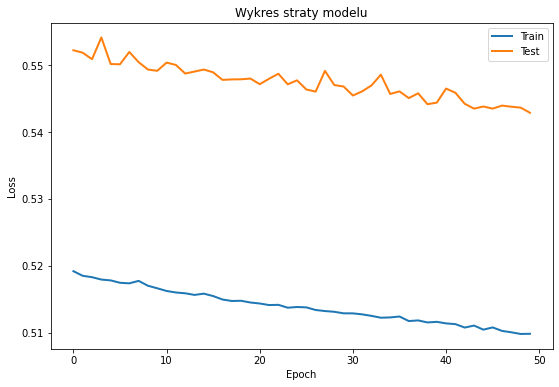

In [8]:
# TEN LISTING OPUSZCZAMY PRZY PONOWNYM PUSZCZANIU SKRYPTU
# niestety algorytm trenowania puściłem dwukrotnie więc punktem startownym są funkcje straty osiągnięte w poprzedniej iteracji
plt.figure(figsize=(9, 6))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Wykres straty modelu')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.savefig(r"E:\page_ds\anomaly_detection\foto\5_ModelLoss_SMOTETomek.png", format="png" , dpi=400, facecolor="White")
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [7]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.542864,0.001668
std,3.260370,0.040805
min,0.028587,0.000000
25%,0.143487,0.000000
50%,0.239144,0.000000
75%,0.418322,0.000000
max,379.039941,1.000000


In [11]:
# predykcja dla warstwy ukrytej enkodera. Najpierw jak wygląda struktura (dość prosta) 
encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 18)                558       
                                                                 
 dense_1 (Dense)             (None, 10)                190       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 814
Trainable params: 814
Non-trainable params: 0
_________________________________________________________________


In [10]:
#test_y
print(test_x.shape) 
print(np.sum(test_y))

(56962, 30)
95


Teraz powtarzamy ćwiczenie dla wielowymiarowej przestrzeni czyli sprowadzam przestrzeń ukrytą do dwóch wymiarów. Pozwoli mi to na przedstawienie graficzne danych

In [7]:
from sklearn.svm import SVC

# tworzę wartswę ukrytą i na niej buduję multiklasowy model SVM 
X_svm = encoder_model.predict(test_x)
y_svm = test_y.copy()

print(X_svm.shape)

(56962, 6)


In [8]:
#rozkład zmiennej 
from collections import Counter
print(sorted(Counter(y_svm).items()))

[(0, 56867), (1, 95)]


Zmienna jest bardzo mocno niezbalansowana, zobaczymy czy model SVM poradzi sobie z tym problemem 

In [40]:
# wyznaczam wartość MSE rekonstrukcji w zależności od parametru gamma
# ćwiczenie bardzo wymagające obliczeniowo, dobrze wykorzystać tylko część zbioru
from sklearn.decomposition import KernelPCA
from sklearn.metrics import mean_squared_error

example_idx = np.random.choice(range(len(X_svm)), 5000)
example_data = X_svm[example_idx]
#example_labels = y_svm[example_idx]

gamma_grid = [0.001, 0.01, 0.03, 0.06, 0.1, 0.2, 0.5]
output = []

for gamma in gamma_grid:
    rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = gamma, fit_inverse_transform=True)
    X_reduced = rbf_pca.fit_transform(example_data) 
    X_preimage = rbf_pca.inverse_transform(X_reduced)
    mse = mean_squared_error(example_data, X_preimage) # dla standardowego PCA można skorzystać z współczynnika wyjaśnionej wariancji
    output.append((gamma, mse))


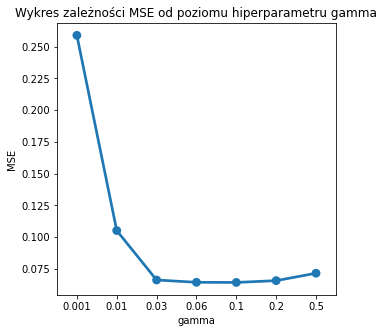

In [41]:
# wykres błedu MSE w zależności od dobotu parametru gamma w moddelu PCA
x = [x[0] for x in output]
y = [y[1] for y in output]

plt.figure(figsize=(5, 5))

sns.pointplot(x=x, y=y)
plt.title("Wykres zależności MSE od poziomu hiperparametru gamma")
plt.xlabel("gamma")
plt.ylabel("MSE")
plt.savefig("MSE_dep_gamma.png", format='png', dpi=300, facecolor="White")

In [42]:
output

[(0.001, 0.2587904),
 (0.01, 0.10522992),
 (0.03, 0.066324666),
 (0.06, 0.064526595),
 (0.1, 0.06440831),
 (0.2, 0.065826446),
 (0.5, 0.07165884)]

Czyli wartość pomiędzy 0.03-0.1 wydaje się optymalna 

I jeszcze analogiczne ćwiczenie dla zwykłego PCA 

In [18]:
from sklearn.decomposition import PCA
import numpy as np

example_idx = np.random.choice(range(len(X_svm)), 5000)
example_data = X_svm[example_idx]

pca = PCA(n_components = 2) 
X_reduced_pca = pca.fit_transform(example_data)
print("Wytłumaczona część wariancji oryginalnej przestrzeni wynosi ", pca.explained_variance_ratio_ )

print("Skumulowana wytłumaczona część wariancji wynosi: ", np.cumsum(pca.explained_variance_ratio_))

# PCA nie posiada inverce transform, trzeba ją zdefiniować samemu
data_reduced = np.dot(example_data - pca.mean_, pca.components_.T) # transform
data_original = np.dot(data_reduced, pca.components_) # inverse_transform
print(mean_squared_error(example_data, data_original))


Wytłumaczona część wariancji oryginalnej przestrzeni wynosi  [0.4858705  0.19943869]
Skumulowana wytłumaczona część wariancji wynosi:  [0.4858705 0.6853092]
0.0686903


Potrafię wytłumaczyć 75% wariancji przy dwóch wymiarach dla PCA liniowej

In [ ]:
# wykonujemy redukcję wymiarów przestrzeni ukrytej przy wyborze jądra rbf oraz parametrze gamma = 0.01
rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.01)
X_reduced = rbf_pca.fit_transform(X_svm)
# ćwiczenie trwa kilkanaście minut, dobrze jest zapisać sobie jego wynik

In [50]:
#Zapisywanie modelu 
import pickle as pk
pk.dump(rbf_pca, open("./run/PCA/PCA01.pkl","wb"))
#zrzucam również dane 
X_reduced.dump('PCA_data.pkl')

In [10]:
# i teraz odczytujemy model
import pickle as pk
pca_reload = pk.load(open("./run/PCA/PCA01.pkl","rb"))
X_reduced = pk.load(open("PCA_data.pkl", "rb"))
# i teraz nie korzystamy jużz fit_transform tylko z samego transform
#result_new = pca_reload.transform(X_svm)


To teraz wykresik :). Dla odmiany pokażę losowy podzbiór normalnych danych oraz wszystkie pozycje fraudowe

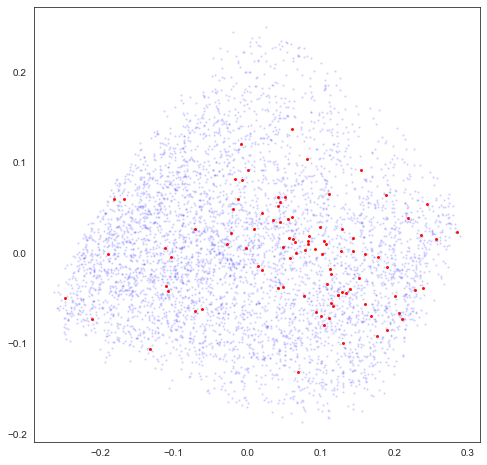

In [42]:
n_to_show = 5000
figsize = 8
# muszę podmienić typ bo na serii nie da się pracować 
y_svm= list(y_svm)
#wszystkie elementy z klasy mniejszościowej
example_idx_1 = [index for index,value in enumerate(y_svm) if value == 1]

#losowy podzbiór z klasy większościowej, wywalam elementy już wybrane z klasy mniejszościowej
example_idx_0 = set(np.random.choice(range(len(X_reduced[:,0])), n_to_show, replace=False))
example_idx_0 = example_idx_0.difference(example_idx_1)
example_idx_0 = list(example_idx_0)

# mapujemy na liczby całkowite, z jakiegoś powodu wywalało mi błąd niepoprawności danych
example_idx_0 = list(map(int,example_idx_0))
example_idx_1 = list(map(int,example_idx_1))

#próbka dla danych z kategorią 0 
example_data_0 = X_reduced[example_idx_0]
example_labels_0 = [y_svm[x] for x in example_idx_0]

#pełen zbiór danych z kategorią 1, jest to klasa mniejszościowa więc można sobie pozwolić
example_data_1 = X_reduced[example_idx_1]
example_labels_1 = [y_svm[x] for x in example_idx_1]

plt.figure(figsize=(figsize, figsize))
plt.scatter(example_data_0[:, 0] , example_data_0[:, 1] ,  c="blue"
            , alpha=0.1, s=2)

plt.scatter(example_data_1[:, 0] , example_data_1[:, 1] ,  c="red"
            , alpha=0.9, s=4)

#plt.colorbar()

#plt.savefig("latent_space_2d.png", format='png', dpi=300, facecolor="White")
plt.show()


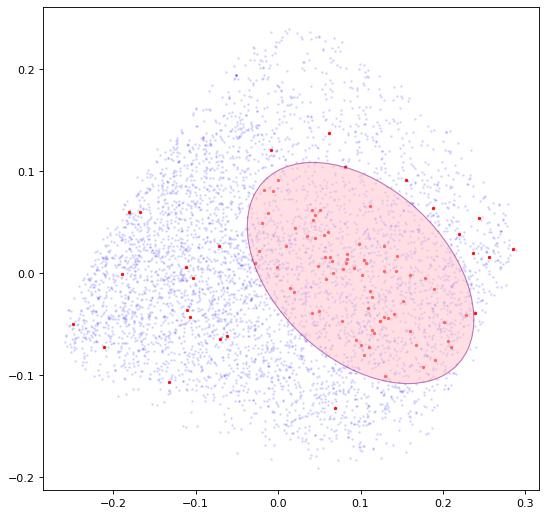

In [24]:
import matplotlib.patches as pch

n_to_show = 5000
figsize = 8
# muszę podmienić typ bo na serii nie da się pracować 
y_svm= list(y_svm)
example_idx_1 = [index for index,value in enumerate(y_svm) if value == 1]

example_idx_0 = set(np.random.choice(range(len(X_reduced[:,0])), n_to_show, replace=False))
example_idx_0 = example_idx_0.difference(example_idx_1)
example_idx_0 = list(example_idx_0)

# mapujemy na liczby całkowite 
example_idx_0 = list(map(int,example_idx_0))
example_idx_1 = list(map(int,example_idx_1))


example_data_0 = X_reduced[example_idx_0]
example_labels_0 = [y_svm[x] for x in example_idx_0]

example_data_1 = X_reduced[example_idx_1]
example_labels_1 = [y_svm[x] for x in example_idx_1]

fig, ax = plt.subplots(figsize=(figsize, figsize),dpi=80) 


ax.scatter(example_data_0[:, 0] , example_data_0[:, 1] ,  c="blue"
            , alpha=0.1, s=2)

ax.scatter(example_data_1[:, 0] , example_data_1[:, 1] ,  c="red"
            , alpha=0.9, s=4)
# wskazanie obszaru największego zagęszczenia 
circle1 = pch.Ellipse((0.1, 0), 0.3, 0.18,angle= -30,  facecolor='pink', edgecolor='purple', fill=True, alpha=0.5) 
ax.add_patch(circle1)
#plt.colorbar()

#plt.savefig("latent_space_2d.png", format='png', dpi=300, facecolor="White")
plt.show()


W dwuwymiarowej przestrzeni nie wygląda to na zbiór wektorów reprezentacji łatwych do rozdzielenia. Należy jednak pamiętać, że jest to rzut z przestrzeni 6D w której trudność w rozdzieleniu niekoniecznie musi już być skomplikowana lecz nie da się tego zobrazować na wykresie dwuwymiarowym. Celem naszego ćwiczenia będzie stworzenie modelu SVM wskazującego na pokazany obszar i przeniesienie hiperparametrów tego modelu na przestrzeń 6D. Zatem do dzieła.  

In [11]:
# granice przestrzeni ukrytej
print(np.min(X_reduced[:,0]), np.max(X_reduced[:,0]))
print(np.min(X_reduced[:,1]), np.max(X_reduced[:,1]))

-0.26248583 0.2932543
-0.19815874 0.25020653


In [12]:
# krok pierwszy - uzupełniam przestrzeń ukrytą o syntetyczne wartości 
import numpy as np
from scipy.spatial import distance

# granica przestrzeni ukrytej [-.27, .3, -.2, .252]
x = np.linspace(-0.27, 0.3, 100)
y = np.linspace(-0.2, 0.252, 100)
xv, yv = np.meshgrid(x,y) 
xv = xv.flatten()
yv = yv.flatten()

# wyjściowa macież parametrów syntetycznych, pelna siatka
fill_grid = np.array(list(zip(xv, yv)))

# macierz odległości pomiędzy elementami syntetycznymi a 
dist_matrix = distance.cdist(fill_grid,X_reduced).min(axis=1)

(0.0, 10.0)

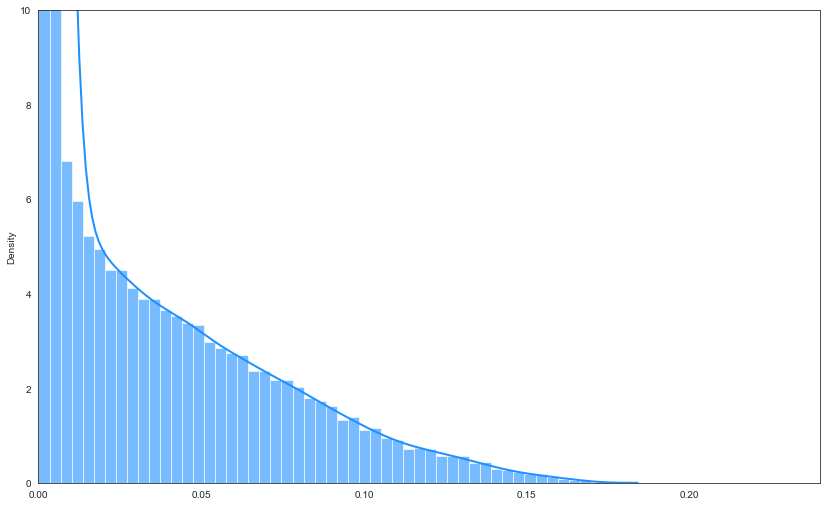

In [18]:
# sprawdzam na jakiej odległości postawić punkt odcięcia
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.simplefilter("ignore")
# warnings.resetwarnings()  # wyłączenie 
sns.set_style("white")
#plt.style.use('ggplot')

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(dist_matrix, color="dodgerblue", **kwargs)
plt.xlim(0,0.24)
plt.ylim(0,10)

#plt.savefig("distance_distribution.png", format='png', dpi=200, facecolor="White")
#plt.hist(dist_matrix, bins=1000)
#plt.show()

In [13]:
# spróbuję z granicą około 0.002
fill_grid_final = fill_grid[dist_matrix>0.002]

In [14]:
fill_grid_final.shape

(4277, 2)

In [23]:
print(X_reduced.shape)
print(len(y_svm))

(56962, 2)
56962


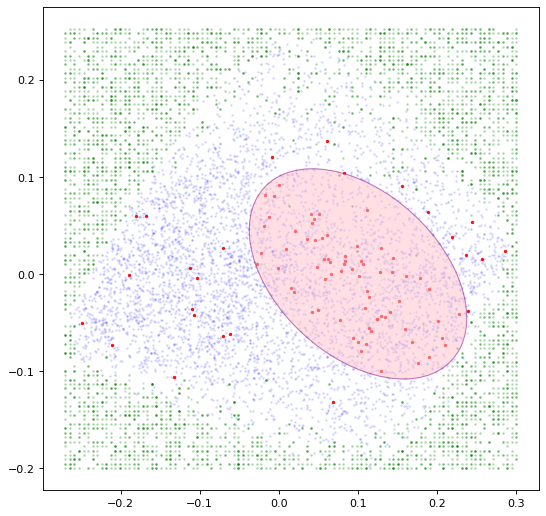

In [27]:
n_to_show = 5000
extra_n_to_show = 5000
figsize = 8
# muszę podmienić typ bo na serii nie da się pracować 
y_svm= list(y_svm)
example_idx_1 = [index for index,value in enumerate(y_svm) if value == 1]
example_idx_fill = np.random.choice(range(len(fill_grid_final)), extra_n_to_show)


example_idx_0 = set(np.random.choice(range(len(X_reduced[:,0])), n_to_show, replace=False))
example_idx_0 = example_idx_0.difference(example_idx_1)
example_idx_0 = list(example_idx_0)

# mapujemy na liczby całkowite 
example_idx_0 = list(map(int,example_idx_0))
example_idx_1 = list(map(int,example_idx_1))

example_data_0 = X_reduced[example_idx_0]
example_labels_0 = [y_svm[x] for x in example_idx_0]
fill_set = fill_grid_final[example_idx_fill]

example_data_1 = X_reduced[example_idx_1]
example_labels_1 = [y_svm[x] for x in example_idx_1]
fill_labels = np.array( np.ones_like(range(extra_n_to_show))*-1) # syntetyczne wartości oznaczam przez -1


fig, ax = plt.subplots(figsize=(figsize, figsize),dpi=80) 

ax.scatter(example_data_0[:, 0] , example_data_0[:, 1] ,  c="blue"
            , alpha=0.1, s=2)

ax.scatter(example_data_1[:, 0] , example_data_1[:, 1] ,  c="red"
            , alpha=0.9, s=4)


ax.scatter(fill_set[:, 0] , fill_set[:, 1] ,  c="green"
            , alpha=0.2, s=2)

# wskazanie obszaru największego zagęszczenia 
circle1 = pch.Ellipse((0.1, 0), 0.3, 0.18,angle= -30,  facecolor='pink', edgecolor='purple', fill=True, alpha=0.5) 
ax.add_patch(circle1)
#plt.colorbar()

#plt.savefig("latent_space_2d.png", format='png', dpi=300, facecolor="White")
plt.show()


In [41]:
def plot_comparitions_fill(clf, axis, clf_par, dta0, dta1, dta_1):
    """ Funkcja do prównywanaia obszaru wyznaczonego przez SVM oraz oryginalne dane"""
    x0s = np.linspace(axis[0], axis[1], 100)
    x1s = np.linspace(axis[2], axis[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xn = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(Xn).reshape(x0.shape)
    #wykresy
    fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
    plt.sca(axes[0])
    plt.contourf(x0, x1, y_pred, cmap='rainbow', levels=[0,1,2],  alpha=0.5)
    plt.colorbar()
    plt.title("Obszar predykcji SVM, C={0}, gamma={1}".format(clf_par[0],clf_par[1]), fontsize=14)
    plt.sca(axes[1])
    
    plt.scatter(dta0[:, 0] , dta0[:, 1] ,  c="blue", alpha=0.1, s=2)
    plt.scatter(dta1[:, 0] , dta1[:, 1] ,  c="red", alpha=0.9, s=4)
    plt.scatter(dta_1[:, 0] , dta_1[:, 1] ,  c="green", alpha=0.2, s=2)

    plt.title(r"Wypełniona przestrzeń ukryta autoenkodera", fontsize=14)
    plt.ylabel("")
    plt.savefig("Fill_compare_for_C{0}_gamma{1}.png".format(clf_par[0],clf_par[1]), format='png', dpi=300, facecolor="White")
    plt.show()

In [35]:
#Stawiam na nowo zbiór uczący dla modelu SVM
X_svm_bis = np.concatenate((X_reduced, fill_grid_final), axis = 0)
y_svm_bis = np.concatenate((y_svm, np.array( np.ones_like(range(len(fill_grid_final)))*2)), axis=0)

In [39]:
print(sorted(Counter(y_svm_bis).items()))

[(0, 56867), (1, 95), (2, 4277)]


Klasa 0 jest klasą istotnie większościową! Dominuje wielokrotnie nad -1 oraz nad 

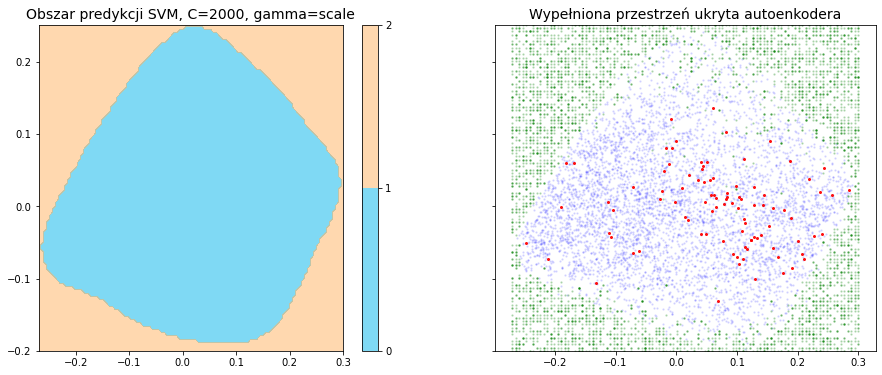

In [42]:
# należy podmienic ovr na ovo bo to zmieniło się w ostatniej wersji na domyślna
Cp =2000  #  0.01, 1000
gammap='scale' # 0.1, 1 'scale' ‘auto’
svm_model  = SVC(kernel='rbf', gamma = gammap, C=Cp, decision_function_shape='ovo')  # kerner = {sigmoid, rbf}
svm_model.fit(X_svm_bis, y_svm_bis)

plot_comparitions_fill(svm_model, [-0.27, 0.3, -0.2, 0.252], [Cp,gammap], example_data_0, example_data_1, fill_set)

Udało się rozdielić klasę syntetyczną od klasy większościowej, niestety klasa mniejszościowa zginęła w tłumie. Muszę zatem zastosować podejście zwiększenia klasy mniejszościowej np. metodą SMOTE

In [12]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_reduced, y_svm)

print(sorted(Counter(y_resampled).items()))

[(0, 56867), (1, 56867)]


In [17]:
from scipy.spatial import distance
# ponawiam generowanie zmiennej syntetycznej
dist_matrix_SMOTE = distance.cdist(fill_grid,X_resampled).min(axis=1)
fill_grid_SMOTE = fill_grid[dist_matrix_SMOTE>0.003] # zwiększam żeby odseparować od danych 

X_SMOTE = np.concatenate((X_resampled, fill_grid_SMOTE), axis = 0)
y_SMOTE = np.concatenate((y_resampled, np.array(np.ones_like(range(len(fill_grid_SMOTE)))*2)), axis=0)

print(sorted(Counter(y_SMOTE).items()))

[(0, 56867), (1, 56867), (2, 3809)]


Teraz klasą mniejszościową jest syntetyczny zbiór uzupełniający przestrzeń (nie mylić z syntetycznymi wartościami klasy mniejszościowej metody SMOTE) 


Text(0.5, 1.0, 'Przestrzeń ukryta wypełniona wartościami spoza zbioru oryginalnych kategorii')

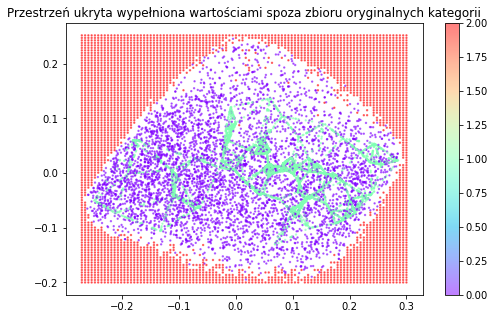

In [18]:
n_to_show = 10000
figsize = 8

example_idx = np.random.choice(range(len(X_resampled)), n_to_show)
example_idx = list(map(int,example_idx))

example_dta_s = X_resampled[example_idx]
example_labels = [y_resampled[x] for x in example_idx]

fill_labels = np.array( np.ones_like(range(len(fill_grid_SMOTE)))*2)

plot_set = np.concatenate((example_dta_s, fill_grid_SMOTE), axis=0)
cat_labels = np.concatenate((example_labels, fill_labels), axis = 0)


plt.figure(figsize=(8, 5))
plt.scatter(plot_set[:, 0] , plot_set[:, 1] , cmap='rainbow' , c= cat_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.title("Przestrzeń ukryta wypełniona wartościami spoza zbioru oryginalnych kategorii")

#plt.savefig("synthetic_points05.png", format='png', dpi=300, facecolor="White")

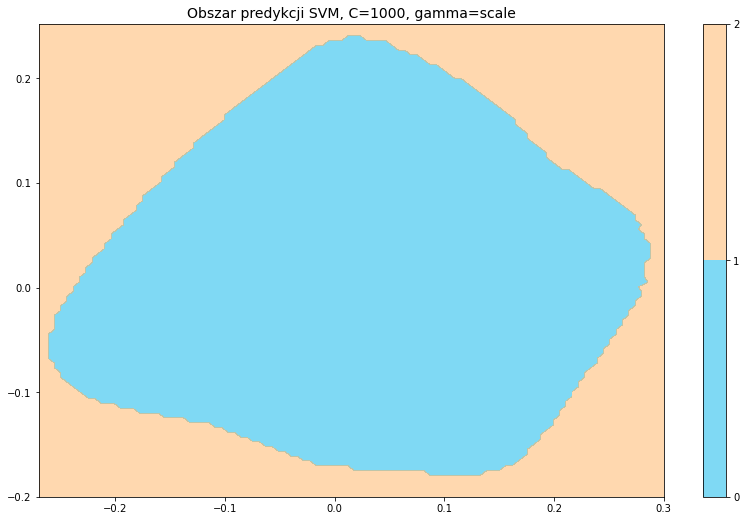

In [28]:
# budowanie na pełnym zbiorze danych trwa zbyt długo, działam zatem jedynie na podziborze jaki wygenerowałem do stworzenia wykresu
Cp =1000  #  0.01, 1000
gammap='scale' # 0.1, 1 'scale' ‘auto’
svm_model  = SVC(kernel='rbf', gamma = gammap, C=Cp, decision_function_shape='ovo')  # kerner = {sigmoid, rbf}
#svm_model.fit(X_SMOTE, y_SMOTE) # tak powinno być ale redukuję zbiór do 10k danych oryginalnych 
svm_model.fit(plot_set, cat_labels)

x0s = np.linspace(-0.27, 0.3, 100)
x1s = np.linspace(-0.2, 0.252, 100)
x0, x1 = np.meshgrid(x0s, x1s)
Xn = np.c_[x0.ravel(), x1.ravel()]
y_pred = svm_model.predict(Xn).reshape(x0.shape)
#wykresy
#fig, axes = plt.subplots(figsize=(15, 6), sharey=True)
plt.contourf(x0, x1, y_pred, cmap='rainbow', levels=[0,1,2],  alpha=0.5)
plt.colorbar()
plt.title("Obszar predykcji SVM, C={0}, gamma={1}".format(Cp,gammap), fontsize=14)
plt.show()

In [29]:
print(sorted(Counter(cat_labels).items()))


[(0, 4970), (1, 5030), (2, 3809)]


Niestety nie rozróżnia klasy 0, która mocno przeplata się z klasą 1. Ponawiam więc resampling danych i tym razem zamiast SMOTE wykorzystam metodę SMOTETomek

In [15]:
from imblearn.combine import SMOTETomek

stom = SMOTETomek(random_state=128262)
X_resampled_ST, y_resampled_ST = stom.fit_resample(X_reduced, y_svm)

print(sorted(Counter(y_resampled_ST).items()))



[(0, 55802), (1, 55802)]


Dla przypomnieniam, metodą SMOTE uzyskaliśmy liczności (0, 56867), (1, 56867)

In [16]:
# ponawiam ćwiczenie z wygenerowaniem zmienych syntetycznych. Ponownie zwiększam odległość od danych rzeczywistych

from scipy.spatial import distance
# ponawiam generowanie zmiennej syntetycznej
dist_matrix_SMOTETomek = distance.cdist(fill_grid,X_resampled_ST).min(axis=1)
fill_grid_SMOTETomek = fill_grid[dist_matrix_SMOTETomek>0.005] # zwiększam żeby odseparować od danych 

X_SMOTETomek = np.concatenate((X_resampled_ST, fill_grid_SMOTETomek), axis = 0)
y_SMOTETomek = np.concatenate((y_resampled_ST, np.array(np.ones_like(range(len(fill_grid_SMOTETomek)))*2)), axis=0)

print(sorted(Counter(y_SMOTETomek).items()))

[(0, 55802), (1, 55802), (2, 3491)]


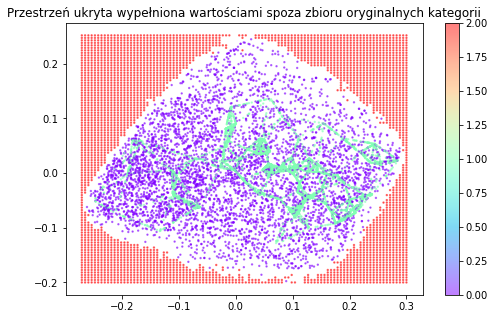

In [25]:
n_to_show = 10000
figsize = 8

example_idx = np.random.choice(range(len(X_resampled_ST)), n_to_show)
example_idx = list(map(int,example_idx))

example_dta_s = X_resampled_ST[example_idx]
example_labels = [y_resampled_ST[x] for x in example_idx]

fill_labels = np.array( np.ones_like(range(len(fill_grid_SMOTETomek)))*2)

plot_set = np.concatenate((example_dta_s, fill_grid_SMOTETomek), axis=0)
cat_labels = np.concatenate((example_labels, fill_labels), axis = 0)


plt.figure(figsize=(8, 5))
plt.scatter(plot_set[:, 0] , plot_set[:, 1] , cmap='rainbow' , c= cat_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.title("Przestrzeń ukryta wypełniona wartościami spoza zbioru oryginalnych kategorii")

plt.savefig("SMOTETomek_latent_space.png", format='png', dpi=300, facecolor="White")

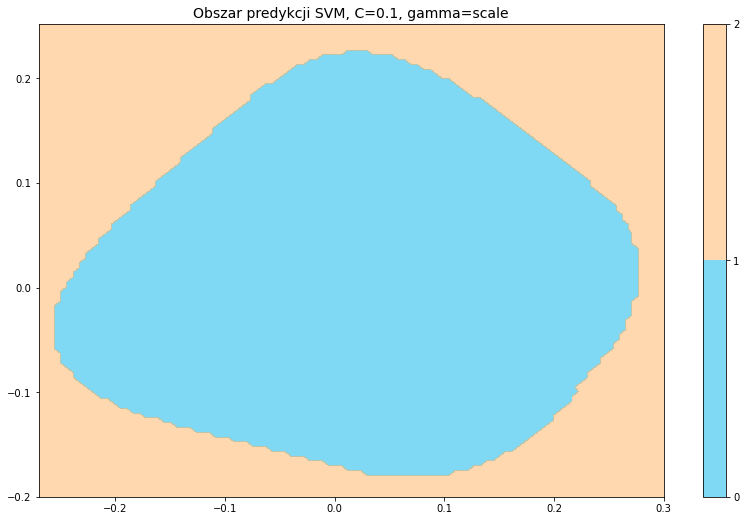

In [24]:
# budowanie na pełnym zbiorze danych trwa zbyt długo, działam zatem jedynie na podziborze jaki wygenerowałem do stworzenia wykresu
Cp =0.1  #  0.01, 1000
gammap='scale' # 0.1, 1 'scale' ‘auto’
svm_model  = SVC(kernel='rbf', gamma = gammap, C=Cp, decision_function_shape='ovo')  # kerner = {sigmoid, rbf}
#svm_model.fit(X_SMOTE, y_SMOTE) # tak powinno być ale redukuję zbiór do 10k danych oryginalnych 
svm_model.fit(plot_set, cat_labels)

x0s = np.linspace(-0.27, 0.3, 100)
x1s = np.linspace(-0.2, 0.252, 100)
x0, x1 = np.meshgrid(x0s, x1s)
Xn = np.c_[x0.ravel(), x1.ravel()]
y_pred = svm_model.predict(Xn).reshape(x0.shape)
#wykresy
#fig, axes = plt.subplots(figsize=(15, 6), sharey=True)
plt.contourf(x0, x1, y_pred, cmap='rainbow', levels=[0,1,2],  alpha=0.5)
plt.colorbar()
plt.title("Obszar predykcji SVM, C={0}, gamma={1}".format(Cp,gammap), fontsize=14)
plt.savefig("SVM_SMOTET.png", format='png', dpi=300, facecolor="White")
plt.show()

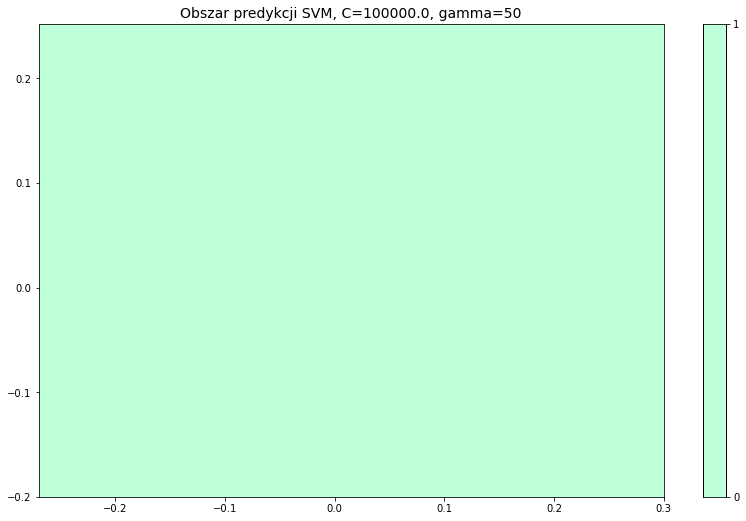

In [19]:
# spróbuję jeszcze wykonać ćwiczenie tylko na zmiennej binarnej
Cp =1e5 #  0.01, 1000
gammap=50 # 0.1, 1 'scale' ‘auto’
svm_model  = SVC(kernel='rbf', gamma = gammap, C=Cp)  # kerner = {sigmoid, rbf}
#svm_model.fit(X_SMOTE, y_SMOTE) # tak powinno być ale redukuję zbiór do 10k danych oryginalnych 
svm_model.fit(example_dta_s, np.array(example_labels))

x0s = np.linspace(-0.27, 0.3, 100)
x1s = np.linspace(-0.2, 0.252, 100)
x0, x1 = np.meshgrid(x0s, x1s)
Xn = np.c_[x0.ravel(), x1.ravel()]
y_pred = svm_model.predict(Xn).reshape(x0.shape)
#wykresy
#fig, axes = plt.subplots(figsize=(15, 6), sharey=True)
plt.contourf(x0, x1, y_pred, cmap='rainbow', levels=[0,1],  alpha=0.5)
plt.colorbar()
plt.title("Obszar predykcji SVM, C={0}, gamma={1}".format(Cp,gammap), fontsize=14)
plt.show()

In [52]:
svm_model.predict(Xn)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [20]:
#Zapisywanie modelu 
import pickle as pk
pk.dump(svm_model, open("./run/SVM_SMOTETpmek_binarny_c1e5_g50.pkl","wb"))

In [21]:
# i teraz odczytujemy model
import pickle as pk
svm_model_ = pk.load(open("./run/SVM_SMOTETpmek_binarny_c1e5_g50.pkl","rb"))

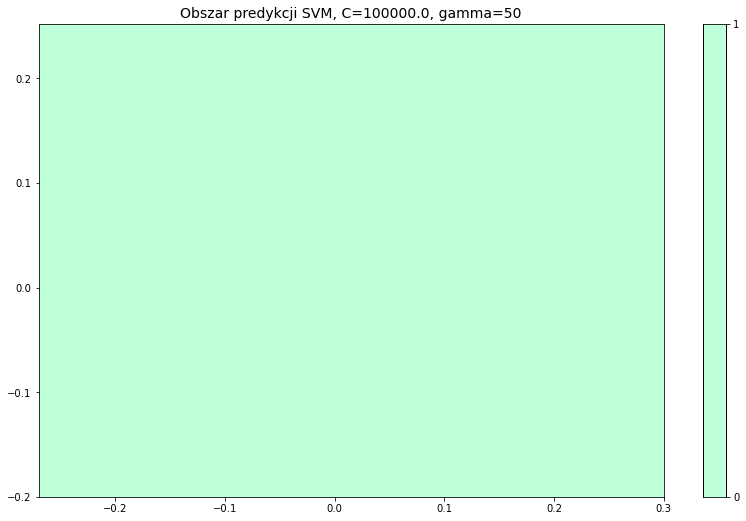

In [23]:
# i teraz odczytujemy model
import pickle as pk
svm_model_ = pk.load(open("./run/SVM_SMOTETpmek_binarny_c1e5_g50.pkl","rb"))

# spróbuję jeszcze wykonać ćwiczenie tylko na zmiennej binarnej
Cp =1e5 #  0.01, 1000
gammap=50 # 0.1, 1 'scale' ‘auto’

x0s = np.linspace(-0.27, 0.3, 100)
x1s = np.linspace(-0.2, 0.252, 100)
x0, x1 = np.meshgrid(x0s, x1s)
Xn = np.c_[x0.ravel(), x1.ravel()]
y_pred = svm_model_.predict(Xn).reshape(x0.shape)
#wykresy
#fig, axes = plt.subplots(figsize=(15, 6), sharey=True)
plt.contourf(x0, x1, y_pred, cmap='rainbow', levels=[0,1],  alpha=0.5)
plt.colorbar()
plt.title("Obszar predykcji SVM, C={0}, gamma={1}".format(Cp,gammap), fontsize=14)
plt.savefig("SVM_SMOTETpmek_binarny_c1e5_g50.png", format='png', dpi=300, facecolor="White")
plt.show()